In [1]:
import os, cv2, warnings
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import f1_score
import multiprocessing as mp

from utils.Dataset import CustomAugmentation, CustomDataset
from utils.models import ResNet50, UnetResnet50
from utils.utils import dense_crf_wrapper

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cpu = torch.device("cpu")
warnings.filterwarnings("ignore")

In [2]:
val_transform = CustomAugmentation('val')
val_dataset = CustomDataset(data_path='../data/QCdataset', mode='val', transform=val_transform)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                        batch_size=1,
                                        shuffle=False,
                                        num_workers=4,
                                        drop_last=False,
                                        pin_memory=(torch.cuda.is_available()),
                                        collate_fn=None)

In [4]:
# test_dataset = CustomDataset(data_path='../data/QCdataset', mode='test', transform=val_transform)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
#                                         batch_size=1,
#                                         shuffle=False,
#                                         num_workers=4,
#                                         drop_last=False,
#                                         pin_memory=(torch.cuda.is_available()),
#                                         collate_fn=None)

In [5]:
model_classification = ResNet50()
model_classification_ori = ResNet50()
model_segmentation = UnetResnet50()
softmax = torch.nn.Softmax()

model_classification.load_state_dict(torch.load('./saved/class1.pt'))
model_classification_ori.load_state_dict(torch.load('./saved/best2.pt'))
model_segmentation.load_state_dict(torch.load('./saved/seg1.pt').state_dict())

model_classification = model_classification.to(device)
model_classification_ori = model_classification_ori.to(device)
model_segmentation = model_segmentation.to(device)

model_classification.eval()
model_classification_ori.eval()
model_segmentation.eval()

UnetResnet50(
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(i

In [6]:
image, label, mask = next(iter(val_loader))
image, mask = image.to(device), mask.to(device)

In [7]:
seg_output = model_segmentation(image)
seg_output.squeeze().size()

torch.Size([2, 224, 224])

In [8]:
rgb_img = image.to(torch.device('cpu')).reshape([3,224,224])
rgb_img = np.array(rgb_img)
rgb_img = (rgb_img-rgb_img.min())/(rgb_img.max()-rgb_img.min())
rgb_img = rgb_img.transpose(1,2,0)
gt_mask = np.array(mask.to(torch.device('cpu')).squeeze())
pred_mask = seg_output.to(torch.device('cpu'))
pred_mask = pred_mask.detach().numpy()[0]

pred_mask[0] = 255*(pred_mask[0]-pred_mask[0].min())/(pred_mask[0].max()-pred_mask[0].min())
pred_mask[1] = 255*(pred_mask[1]-pred_mask[1].min())/(pred_mask[1].max()-pred_mask[1].min())
pred_mask[1].shape

(224, 224)

In [9]:
_, pred_mask_th = cv2.threshold(pred_mask[1], 127, 255, cv2.THRESH_BINARY)
# _, pred_mask_th = cv2.threshold(pred_mask[1].astype('uint8'), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
pred_mask_th = pred_mask_th/255
pred_mask_th.dtype, pred_mask_th.shape, pred_mask_th.max()

(dtype('float32'), (224, 224), 1.0)

In [10]:
classification_input_rgb = rgb_img*cv2.cvtColor(pred_mask_th, cv2.COLOR_GRAY2RGB)
print(classification_input_rgb.shape)

classification_input, _ = val_transform(image=classification_input_rgb, mask=classification_input_rgb)
# classification_input = torch.tensor(classification_input)
# classification_input = classification_input.permute(2,0,1).unsqueeze(0)

classification_input = classification_input.unsqueeze(0).to(device)
classification_input.size()

(224, 224, 3)


torch.Size([1, 3, 224, 224])

In [20]:
mask_numpy = mask.squeeze().to(cpu).detach().cpu().numpy()
masked_rgb_img = rgb_img*cv2.cvtColor(mask_numpy, cv2.COLOR_GRAY2RGB)
mask_numpy.shape, masked_rgb_img.shape

((224, 224), (224, 224, 3))

In [21]:
probs_crf = torch.nn.functional.softmax(seg_output, dim=1).detach().cpu().numpy()
pool = mp.Pool(mp.cpu_count())
images_ = image.detach().cpu().numpy().astype(np.uint8).transpose(0, 2, 3, 1)
probs_crf = np.array(pool.map(dense_crf_wrapper, zip(images_, probs_crf)))
pool.close()

In [22]:
class_output = model_classification(classification_input)
class_prob = softmax(class_output.squeeze())
class_prob = class_prob.to(torch.device('cpu')).detach().numpy()
# class_output.squeeze(), class_output.squeeze().argmax(), label[0], 100*class_prob

In [23]:
class_output_ori = model_classification_ori(image)
class_prob_ori = softmax(class_output_ori.squeeze())
class_prob_ori = class_prob_ori.to(torch.device('cpu')).detach().numpy()
# class_output_ori.squeeze(), class_output_ori.squeeze().argmax(), label[0], 100*class_prob_ori

predicted class: 2, gt class: 0
predicted class: 1, gt class: 0
predicted prob:  25.34% 16.13% 34.23% 5.81% 18.48% 
predicted prob:  39.11% 60.50% 0.39% 0.00% 0.00% 


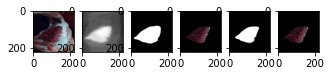

In [25]:
plt.subplot(1, 7, 1) 
plt.imshow(rgb_img)
plt.subplot(1, 7, 2) 
plt.imshow(pred_mask[1], cmap='gray')
plt.subplot(1, 7, 3) 
plt.imshow(pred_mask_th, cmap='gray')
plt.subplot(1, 7, 4) 
plt.imshow(masked_rgb_img, cmap='gray')
plt.subplot(1, 7, 5) 
plt.imshow(gt_mask, cmap='gray')
plt.subplot(1, 7, 6) 
plt.imshow(classification_input_rgb)
plt.subplot(1, 7, 7) 
plt.imshow(masked_rgb_img)
plt.savefig('img1.jpg')
print(f'predicted class: {class_output.squeeze().argmax()}, gt class: {label[0]}')
print(f'predicted class: {class_output_ori.squeeze().argmax()}, gt class: {label[0]}')
print('predicted prob: ', end=" ")
for prob in class_prob:
    print(f'{100*prob:.2f}%', end=" ")
print()
print('predicted prob: ', end=" ")
for prob in class_prob_ori:
    print(f'{100*prob:.2f}%', end=" ")
print()

In [100]:
preds = []
preds_ori = []
gt = []
correct = 0
correct_ori = 0
total = 0
label_list = [i for i in range(5)]
for step, (image, label, mask) in enumerate(val_loader):
    image, label, mask = image.to(device), label.to(device), mask.to(device)

    seg_output = model_segmentation(image)

    rgb_img = image.to(torch.device('cpu')).reshape([3,224,224])
    rgb_img = np.array(rgb_img)
    rgb_img = (rgb_img-rgb_img.min())/(rgb_img.max()-rgb_img.min())
    rgb_img = rgb_img.transpose(1,2,0)
    gt_mask = np.array(mask.to(torch.device('cpu')).squeeze())
    pred_mask = seg_output.to(torch.device('cpu'))
    pred_mask = pred_mask.detach().numpy()[0]

    pred_mask[0] = 255*(pred_mask[0]-pred_mask[0].min())/(pred_mask[0].max()-pred_mask[0].min())
    pred_mask[1] = 255*(pred_mask[1]-pred_mask[1].min())/(pred_mask[1].max()-pred_mask[1].min())

    _, pred_mask_th = cv2.threshold(pred_mask[1], 191, 255, cv2.THRESH_BINARY)

    classification_input_rgb = rgb_img*cv2.cvtColor(pred_mask_th, cv2.COLOR_GRAY2RGB)
    classification_input, _ = val_transform(image=classification_input_rgb, mask=classification_input_rgb)
    classification_input = classification_input.unsqueeze(0).to(device)

    # crf
    pool = mp.Pool(mp.cpu_count())
    images_ = image.detach().cpu().numpy().astype(np.uint8).transpose(0, 2, 3, 1)
    probs = np.array(pool.map(dense_crf_wrapper, zip(images_, probs)))
    pool.close()


    class_output = model_classification(classification_input)
    class_prob = softmax(class_output.squeeze())
    class_prob = class_prob.to(torch.device('cpu')).detach().numpy()

    class_output_ori = model_classification_ori(image)
    class_prob_ori = softmax(class_output_ori.squeeze())
    class_prob_ori = class_prob_ori.to(torch.device('cpu')).detach().numpy()

    _, pred = torch.max(class_output, 1)
    _, pred_ori = torch.max(class_output_ori, 1)

    total += label.size(0)
    correct += (pred == label).sum().item()
    correct_ori += (pred_ori == label).sum().item()

    preds += pred.to("cpu").tolist()
    preds_ori += pred_ori.to("cpu").tolist()
    gt += label.to("cpu").tolist()

    accuracy = correct / total
    accuracy_ori = correct_ori / total
    f1 = f1_score(y_true=gt, y_pred=preds, labels=label_list, average="macro", zero_division=0)
    f1_ori = f1_score(y_true=gt, y_pred=preds_ori, labels=label_list, average="macro", zero_division=0)

    print(f'{step+1}/{len(val_dataset)} - accuracy:{accuracy}/{accuracy_ori}, f1:{f1}/{f1_ori}', end='\r')


In [31]:
gt = np.array(gt)
preds = np.array(preds)
preds_ori = np.array(preds_ori)

In [95]:
i = 0
len(gt), gt, preds, preds_ori

(8679,
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0

In [50]:
for i in range(5):
    f1 = f1_score(y_true=gt[gt==i], y_pred=preds[gt==i], labels=label_list, average="macro", zero_division=0)
    f1_ori = f1_score(y_true=gt[gt==i], y_pred=preds_ori[gt==i], labels=label_list, average="macro", zero_division=0)

    print(f'{i} - f1:{f1}/{f1_ori}')

0 - f1:0.2/0.2
1 - f1:0.0/0.0
2 - f1:0.0/0.0
3 - f1:0.0/0.0
4 - f1:0.0/0.0


# =================================

1

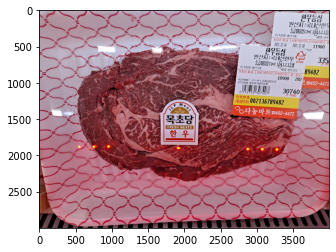

In [14]:
# test_file_path = '../data/QCdataset/images/test/two/20211214_170105.jpg'
test_file_path = '../data/QCdataset/images/test/onep/20211214_151925.jpg'

eng_to_label = {'one':0, 'onep':1, 'onepp':2, 'three':3, 'two':4}
label = eng_to_label[test_file_path.split('/')[5]]

image_bgr = cv2.imread(test_file_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
label

In [126]:
image = torch.tensor(image_rgb)
print(image.size())
image, _ = val_transform(image, image)
print(image.size())
image = image.unsqueeze(0)
print(image.size())
image = image.to(device)

torch.Size([3000, 4000, 3])
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


In [127]:
seg_output = model_segmentation(image)
seg_output.squeeze().size()

rgb_img = image.to(torch.device('cpu')).reshape([3,224,224])
rgb_img = np.array(rgb_img)
rgb_img = (rgb_img-rgb_img.min())/(rgb_img.max()-rgb_img.min())
rgb_img = rgb_img.transpose(1,2,0)
gt_mask = np.array(mask.to(torch.device('cpu')).squeeze())
pred_mask = seg_output.to(torch.device('cpu'))
pred_mask = pred_mask.detach().numpy()[0]

pred_mask[0] = 255*(pred_mask[0]-pred_mask[0].min())/(pred_mask[0].max()-pred_mask[0].min())
pred_mask[1] = 255*(pred_mask[1]-pred_mask[1].min())/(pred_mask[1].max()-pred_mask[1].min())

_, pred_mask_th = cv2.threshold(pred_mask[1], 127, 255, cv2.THRESH_BINARY)

In [128]:
classification_input_rgb = rgb_img*cv2.cvtColor(pred_mask_th, cv2.COLOR_GRAY2RGB)/255
print(classification_input_rgb.shape)
classification_input = torch.tensor(classification_input_rgb)

classification_input = classification_input.permute(2,0,1).unsqueeze(0)
classification_input = classification_input.to(device)
classification_input.size()

(224, 224, 3)


torch.Size([1, 3, 224, 224])

In [129]:
class_output = model_classification(classification_input)
class_prob = softmax(class_output.squeeze())
class_prob = class_prob.to(torch.device('cpu')).detach().numpy()
# class_output.squeeze(), class_output.squeeze().argmax(), label[0], 100*class_prob

/opt/conda/envs/lightweight/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [130]:
class_output_ori = model_classification_ori(image)
class_prob_ori = softmax(class_output_ori.squeeze())
class_prob_ori = class_prob_ori.to(torch.device('cpu')).detach().numpy()
# class_output_ori.squeeze(), class_output_ori.squeeze().argmax(), label[0], 100*class_prob_ori

/opt/conda/envs/lightweight/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


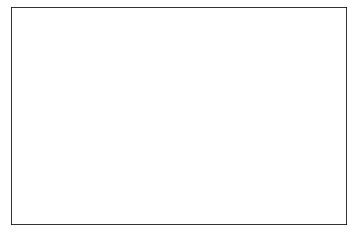

In [143]:
classification_input_rgb.max()
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

predicted class: 1, only classification predicted: 2, gt class: 1
predicted prob:  34.34% 39.51% 20.49% 0.01% 5.65% 
only classification predicted prob:  27.37% 33.05% 37.47% 0.05% 2.06% 


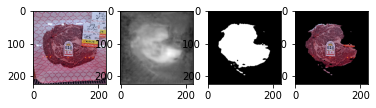

In [145]:
plt.subplot(1, 4, 1) 
plt.imshow(rgb_img)
plt.subplot(1, 4, 2) 
plt.imshow(pred_mask[1], cmap='gray')
plt.subplot(1, 4, 3) 
plt.imshow(pred_mask_th, cmap='gray')
plt.subplot(1, 4, 4) 
plt.imshow(classification_input_rgb)

plt.savefig('img3.jpg')
print(f'predicted class: {class_output.squeeze().argmax()}, only classification predicted: {class_output_ori.squeeze().argmax()}, gt class: {label}')
print('predicted prob: ', end=" ")
for prob in class_prob:
    print(f'{100*prob:.2f}%', end=" ")
print()
print('only classification predicted prob: ', end=" ")
for prob in class_prob_ori:
    print(f'{100*prob:.2f}%', end=" ")
print()

#   =================